In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch, QuatBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_grav_ref
from pipelines import integrate_gyro_grav
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"

for p in [ori_path, gyro_path, grav_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

g_ref_interp = load_grav_ref(grav_path, t_new)

In [4]:
q0: Quat = q_ref_interp[0].copy()
K: float = 0.05
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))
q_gyro_grav: QuatBatch = integrate_gyro_grav(q0, w_avg_gyro, dt,
                                             K, g_world_unit, g_ref_interp)

angle_err_gyro_grav: ScalarBatch = calc_angle_err(q_gyro_grav, q_ref_interp)
print_err_status("Gyro + Gravity", angle_err_gyro_grav)

Gyro + Gravity angle error in rad — min/max/mean
0.0002787963696693779 0.951452095442838 0.1905944435717342

Gyro + Gravity angle error in deg — min/max/mean
0.015973855325624467 54.51418947775301 10.920257215304693


In [5]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "02_angle_err_gyro_grav.csv"
save_err_csv(out_path, t_new, angle_err_gyro_grav)

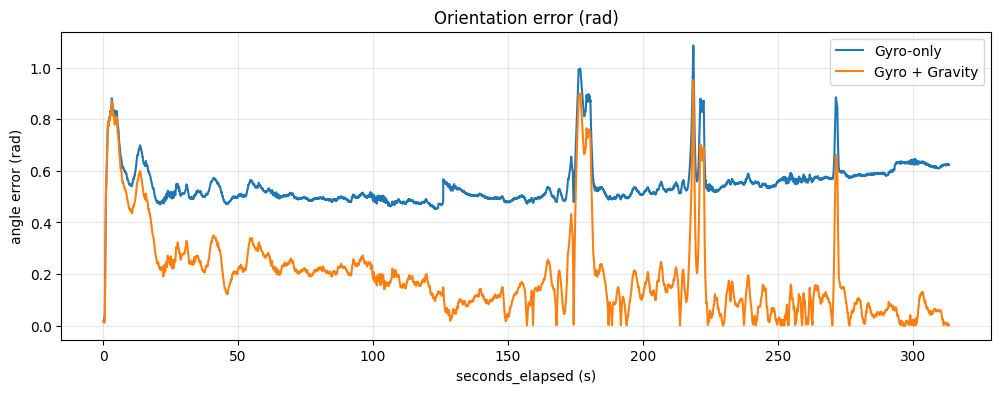

In [6]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"
out_grav_path = out_dir / "02_angle_err_gyro_grav.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro + Gravity", out_grav_path)
])